# Rastreamento de objetos e machine learning

Rastreamento de cores, objetos e aplicação de técnicas de machine learning pré-treinadas e desenvolvimento de algoritmos próprios.

Alguns recursos e códigos foram adaptados deste [repositório](https://github.com/udacity/CVND_Exercises/) do curso de Visão Computacional da Udacity.

** Importante ressaltar que precisamos do OpenCV >= 3.4.2. Pode ser instalado pelo comando**

```conda install -c conda-forge opencv```

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print(cv2.__version__)

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

#plt.rcParams["figure.figsize"]\
#(8,5)

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

import datetime

import dlib

from os import listdir
from os.path import isfile, join

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

/Users/michel.fernandes/anaconda/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


3.4.2


Verificando versão instalada do OpenCV

## Machine Learning

### Reconhecimento Facial

Gerando 100 exemplos de faces, utilizando a câmera.

In [26]:
# Extrator de faces
def face_extractor(imagem):
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_RGB2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        face_recortada = imagem[y:y+h, x:x+w]

    return face_recortada

** Extração de Características **

Gerando imagems de exemplos para ser posteriormente treinado. Neste caso vamos adotar um tamanho de imagem para processamento de 200 x 200 (empírico).

Text(0.5,1,'Extração de faces')

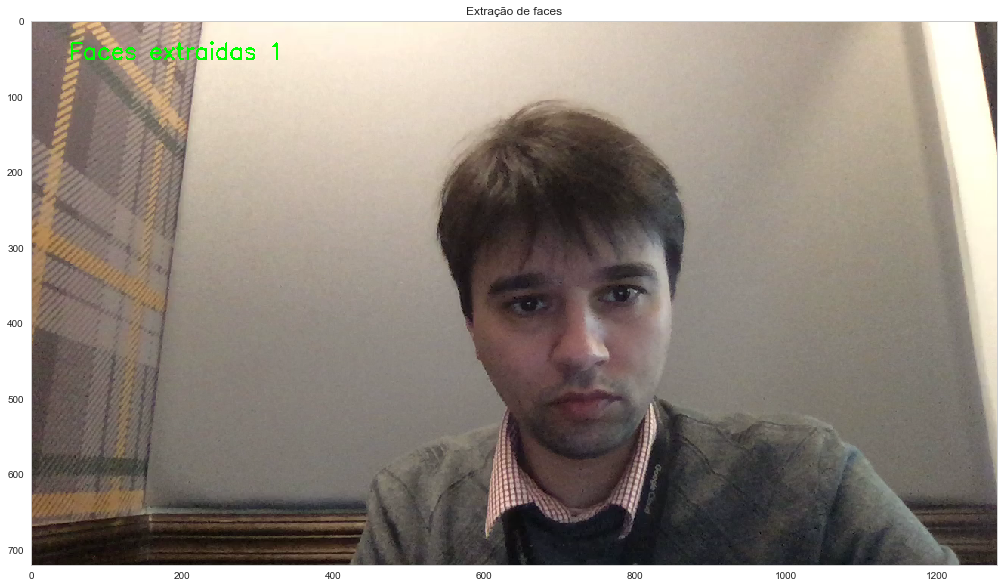

In [4]:
imagem = cv2.imread("imagens/camera_output_1.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Extração de faces")

### Windows

In [ ]:
cam_capture = cv2.VideoCapture(0)

contador = 0

while contador <= 99:
    ret, frame = cam_capture.read()
    
    if ret:
        if face_extractor(frame) is not None:
            contador += 1

            face = cv2.resize(face_extractor(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            imagem_path = 'imagens/faces/michel/' + str(contador) + '.jpg'
            cv2.imwrite(imagem_path, face)

            cv2.putText(frame, "Faces extraidas " +  str(contador), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow("Tracos", frame)
        
    if cv2.waitKey(1) == 13:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

### MacOS

In [42]:
cam_capture.release()
cam_capture = cv2.VideoCapture(0)

contador = 0

try:
    while contador <= 99:
        ret, frame = cam_capture.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            if face_extractor(frame) is not None:
                contador += 1

                face = cv2.resize(face_extractor(frame), (200, 200))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                imagem_path = 'imagens/faces/michel/' + str(contador) + '.jpg'
                cv2.imwrite(imagem_path, face)
            
                cv2.putText(frame, "Faces extraidas " +  str(contador), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            #cv2.imshow('Rosto Normalizado', face)
            
            img = PIL.Image.fromarray(frame, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))

            cv2.imwrite("imagens/camera_output_1.png", frame)

            clear_output(wait=True)
except KeyboardInterrupt:
    cam_capture.release()
    print("Interrompido")

Interrompido


**Treinamento do modelo**

Podemos testar os diversos tipos de classificadores, no entanto, o classificador LBPH tem o uso com melhor performance dentre o Eingenfaces e Fisherfaces.
Neste caso como temos apenas uma única pessoa, nosso dicionário de pessoas, ficou apenas com um único registro. Em casos de multiclasses, ou seja, mais de uma pessoa, cada uma delas deve ter um *id* associado, que é o valor de chave do dicionário.

In [28]:
# Carregando exemplos de arquivos previamente coletados
faces_path = 'imagens/faces/michel/'
lista_arquivos_imagens = [f for f in listdir(faces_path) if isfile(join(faces_path, f))]

dados_treinamento, labels = [], []

# Lendo as imagens e associando a um label
for i, arquivos in enumerate(lista_arquivos_imagens):
    imagem_path = faces_path + lista_arquivos_imagens[i]
    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)
    dados_treinamento.append(imagem)
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
#model = cv2.face.FisherFaceRecognizer_create()
#model = cv2.face.EigenFaceRecognizer_create()
model.train(dados_treinamento, labels)

print("Modelo treinado com sucesso.")

pessoas = {0: "Michel"}

Modelo treinado com sucesso.


**Inferência do modelo**

Função para identificar o rosto e segmentar da imagme principal. Também utilizaremos para desenhar um retângulo delimitador.
Note que estamos normalizando a imagem (mesma escala, 200 x 200) que as imagens de treinamento.

In [33]:
def face_detector(imagem):
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_RGB2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.1, 5)
    
    if faces is ():
        return imagem, [], 0, 0
    
    for (x,y,w,h) in faces:
        cv2.rectangle(imagem,(x,y),(x+w,y+h),(0,255,255),2)
        roi = imagem[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))
    
    return imagem, roi, x, y

Obtendo as imagems por meio da câmera e fazendo a inferência on-line.

Text(0.5,1,'Inferência do modelo')

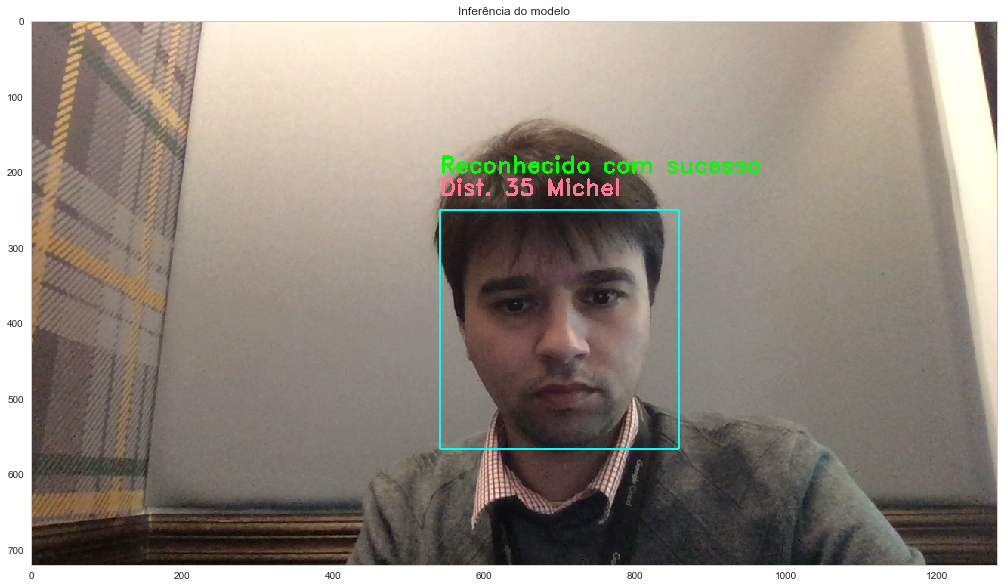

In [6]:
imagem = cv2.imread("imagens/camera_output_2.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Inferência do modelo")

### Windows

In [ ]:
cam_capture = cv2.VideoCapture(0)

while True:
    ret, frame = cam_capture.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        imagem, face, x, y = face_detector(frame)

        if face is not ():
            face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
            predicao = model.predict(face)

            if x > 0:
                notificacao = "Dist. " + str(int(predicao[1])) + ' ' + pessoas[predicao[0]] 
                cv2.putText(frame, notificacao, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

            if int(predicao[1]) < 40:
                cv2.putText(frame, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
            else:
                cv2.putText(frame, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
                
        cv2.imshow("Tracos", frame)
    if cv2.waitKey(1) == 13:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

### MacOS

In [46]:
cam_capture.release()
cam_capture = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cam_capture.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            imagem, face, x, y = face_detector(frame)

            if face is not ():
                face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
                predicao = model.predict(face)
                
                if x > 0:
                    notificacao = "Dist. " + str(int(predicao[1])) + ' ' + pessoas[predicao[0]] 
                    cv2.putText(frame, notificacao, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

                if int(predicao[1]) < 40:
                    cv2.putText(frame, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
                else:
                    cv2.putText(frame, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
                
            #cv2.imshow('Rosto Normalizado', face)
            
            img = PIL.Image.fromarray(frame, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))

            cv2.imwrite("imagens/camera_output_2.png", frame)

            clear_output(wait=True)
except KeyboardInterrupt:
    cam_capture.release()
    print("Interrompido")

Interrompido


### Reconhecimento de caracteres (OCR)

Treinamento de classificador baseado em uma imagem de dígitos numéricos de 0 a 9.
Referencie a este [deep-learning-mnist.ipynb](deep-learning-mnist.ipynb) notebook.

Preparando funções para identificar um dígito a partir de uma nova imagem

In [67]:
def contorno_centroide(contorno):
    # Obtem centróide X
    M = cv2.moments(contorno)
    centroide = int(M["m10"]/M["m00"])
    return centroide

In [56]:
def converter_quadrado(imagem):
    # Transforma uma imagem no formato quadrado (dimensões iguais)
    preenchimento_vazio = [0,0,0]
    
    height = imagem.shape[0]
    width = imagem.shape[1]

    if (height == width):
        return imagem
    else:
        duplicar_tamanho = cv2.resize(imagem, (2*width, 2*height), interpolation = cv2.INTER_CUBIC)
        height = height * 2
        width = width * 2
        if (height > width):
            pad = int((height - width)/2)
            duplicar_tamanho_quadrado = cv2.copyMakeBorder(duplicar_tamanho, 0, 0, pad, pad,
                                                           cv2.BORDER_CONSTANT, value=preenchimento_vazio)
        else:
            pad = int((width - height)/2)
            duplicar_tamanho_quadrado = cv2.copyMakeBorder(duplicar_tamanho, pad, pad, 0, 0,
                                                   cv2.BORDER_CONSTANT, value=preenchimento_vazio)
    
    return duplicar_tamanho_quadrado

In [48]:
from keras.models import load_model
model = load_model("modelos/model-minst.h5")  
model.load_weights("pesos/weights-minst.h5")
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 607,394
Trainable params: 607,394
Non-trainable params: 0
_________________________________________________________________


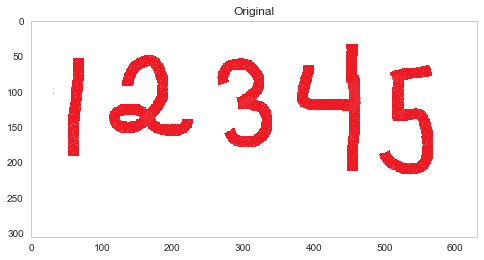

In [49]:
import numpy as np
import cv2

# Carregando imagem para detecção
imagem = cv2.imread('imagens/numeros.png')
imagem = cv2.cvtColor(imagem,cv2.COLOR_BGR2RGB)
imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 10))
plt.title("Original")
plt.imshow(imagem)

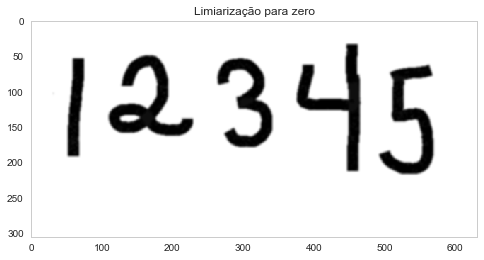

In [50]:
# Suavizando a imagem para posterior detecção de borda por Canny 

imagem_suavizada = cv2.GaussianBlur(imagem_gray, (7, 7), 0)
plt.figure(figsize=(8, 10))
plt.title("Limiarização para zero")
plt.imshow(imagem_suavizada, cmap="gray")

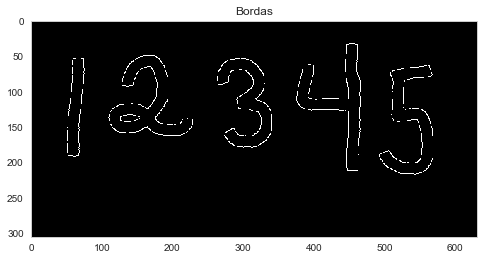

In [51]:
imagem_bordas = cv2.Canny(imagem_suavizada, 30, 150)
plt.figure(figsize=(8, 10))
plt.title("Bordas")
plt.imshow(imagem_bordas, cmap="gray")

Utilizamos a função de enquadramento **converter_quadrado** para lidar quando o dígito é muito pequeno, como por exemplo o dígito 1. Deste modo é criado uma imagem com bordas para que o classificador seja capaz de inferir adequadamente, ou seja, da mesma forma com que foi treinado.

Text(0.5,1,'Dígito 1 sem enquadramento')

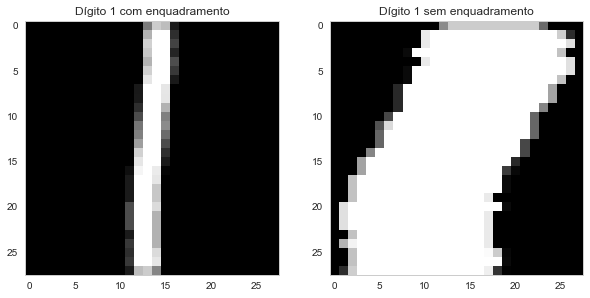

In [70]:
plt.figure(figsize=(10,5))

imagem_quadrado = cv2.imread('imagens/digit_1.png')
imagem_n_quadrado = cv2.imread('imagens/digit_nq1.png')


#Composição Vermelha
plt.subplot(1,2,1)
plt.imshow(imagem_quadrado)
plt.title("Dígito 1 com enquadramento")

#Composição Verde
plt.subplot(1,2,2)
plt.imshow(imagem_n_quadrado)
plt.title("Dígito 1 sem enquadramento")

(28, 28)
1
(28, 28)
2
(28, 28)
3
(28, 28)
4
(28, 28)
5
Numero identificado 12345


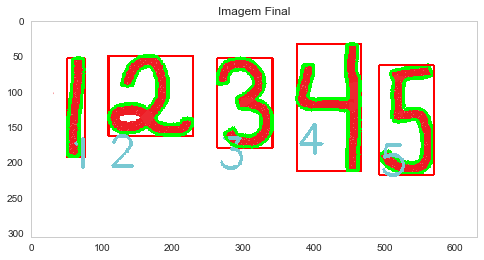

In [69]:
# Encontrando contornos
im2, contornos, hierarchy = cv2.findContours(imagem_bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenando contornos pela coordenada X
contornos = sorted(contornos, key = contorno_centroide, reverse = False)

full_number = []

imagem_contornos = imagem.copy()
cont = 0
for c in contornos:
    cont = cont + 1
    # Para cada contorno, desenhar um retângulo para capturar a escrita
    (x, y, w, h) = cv2.boundingRect(c)    
    cv2.drawContours(imagem_contornos, contornos, -1, (0,255,0), 3)
    
    # Validando tamanho da imagem
    if w >= 5 and h >= 25:
        roi = imagem_suavizada[y:y + h, x:x + w]
        ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
        
        imagem_quadrado = converter_quadrado(roi)
        
        #cv2.imwrite("digit_" + str(cont) + ".png", imagem_quadrado)
        #cv2.imwrite("digit_" + str(cont) + ".png", cv2.resize(imagem_quadrado, (28,28), interpolation = cv2.INTER_AREA))
        
        final = cv2.resize(imagem_quadrado, (28,28), interpolation = cv2.INTER_AREA)
        
        print(final.shape)
        pred = model.predict(final.reshape(1, 28, 28, 1))
        
        number = str(pred.argmax())
        full_number.append(number)
        
        # Retângulo em volta do dígito e número identificado
        cv2.rectangle(imagem_contornos, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(imagem_contornos, number, (x , y + 155), cv2.FONT_ITALIC, 2, (120, 200, 210), 3)
        print(number)

         
plt.figure(figsize=(8, 10))
plt.title("Imagem Final")
plt.imshow(imagem_contornos, cmap="gray")

print ("Numero identificado " + ''.join(full_number))

### Classificador de Faces

Gerando 100 exemplos de faces, utilizando a webcam.

In [6]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

# Extrator de faces
def face_extractor(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

cap = cv2.VideoCapture(0)
count = 0

# Coletar 100 exemplos de um determinado rosto
while True:
    ret, frame = cap.read()
    if ret:
        cv2.imshow("Amostra", frame)
        if face_extractor(frame) is not None:
            count += 1
            face = cv2.resize(face_extractor(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            file_name_path = 'imagens/faces/michel/' + str(count) + '.jpg'
            cv2.imwrite(file_name_path, face)

            # Put count on images and display live count
            cv2.putText(face, str(count), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imshow('Rosto Normalizado', face)

        if cv2.waitKey(1) == 13 or count == 100: #13 is the Enter Key
            break
        
cap.release()
cv2.destroyAllWindows()      
print("Colega de amostras completado")

Colega de amostras completado


Treinamento do modelo

In [9]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

# Carregando exemplos de arquivos previamente coletados
data_path = 'imagens/faces/michel/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]

training_data, labels = [], []

# Lendo as imagens e associando a um label
for i, files in enumerate(onlyfiles):
    image_path = data_path + onlyfiles[i]
    images = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    training_data.append(images)
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
#model = cv2.face.EigenFaceRecognizer_create()
model.train(training_data, labels)

print("Modelo treinado com sucesso.")

persons = {0: "Michel"}

Modelo treinado com sucesso.


Implementando modelo

In [10]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def face_detector(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.1, 5)
    if faces is ():
        return img, [], 0, 0
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        roi = img[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))
    return img, roi, x, y

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    image, face, x, y = face_detector(frame)
    
    try:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        results = model.predict(face)
        
        print(results)
        
        if x > 0:
            display_string = "Dist. " + str(int(results[1])) + ' ' + persons[results[0]] 
            cv2.putText(image, display_string, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

        if int(results[1]) < 40:
            cv2.putText(image, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
            cv2.imshow('Face Recognition', image)
        else:
            cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
            cv2.imshow('Face Recognition', image)
    except:
        cv2.putText(image, "Rosto nao identificado", (220, 120) , cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.putText(image, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
        cv2.imshow('Face Recognition', image )
        
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()     

(0, 38.118317469435404)
(0, 38.34760165494925)
(0, 37.838130769870425)
(0, 38.17568832954155)
(0, 37.877374278012034)
(0, 36.94028740711946)
(0, 36.780750440857254)
(0, 37.421350258682175)
(0, 37.576361588710405)
(0, 37.71325066975237)
(0, 37.32211500569863)
(0, 36.45904823468689)
(0, 37.105901697693554)
(0, 37.12610623929233)
(0, 36.28899081293288)
(0, 36.83765300378565)
(0, 37.30300871971457)
(0, 36.79097519145297)
(0, 36.84635222832929)
(0, 36.35871963161574)
(0, 35.61867431192314)
(0, 36.04858560765531)
(0, 36.29018230115487)
(0, 35.847407993521024)
(0, 32.502484249169335)
(0, 31.013332365988706)
(0, 26.820080050648652)
(0, 24.206606110261188)
(0, 26.757914845598005)
(0, 25.419716525007885)
(0, 25.079785065015084)
(0, 29.40293422044869)
(0, 26.837450212974932)
(0, 25.709704024607063)
(0, 25.42619664334167)
(0, 25.202995465385307)
(0, 25.600205888140106)
(0, 24.782492120623562)
(0, 24.34670377781189)
(0, 26.736062340756707)
(0, 123.30684338096917)
(0, 27.362073706867413)
(0, 26.8559

(0, 44.09242277893189)
(0, 47.00575802878341)
(0, 46.95019992627918)
(0, 47.670274566947604)
(0, 50.16568696732048)
(0, 48.971160891885965)
(0, 48.309343154222745)
(0, 49.60712899930063)
(0, 48.849388238864265)
(0, 49.18107899629187)
(0, 51.11603575311437)
(0, 48.948289322127984)
(0, 51.5502748324688)
(0, 49.546776084255605)
(0, 50.405415866814586)
(0, 50.575005333432294)
(0, 50.93708005355217)
(0, 51.41979186521347)
(0, 51.648201932972256)
(0, 51.884113892991564)
(0, 52.575427917567524)
(0, 57.88207060271019)
(0, 51.63591218603911)
(0, 50.93814766332212)
(0, 50.79687728112255)
(0, 49.1558448871536)
(0, 49.871354183398104)
(0, 49.87779684368234)
(0, 49.69533455657069)
(0, 50.3601681162933)
(0, 49.56539646374138)
(0, 47.9520623504157)
(0, 48.70622282483802)
(0, 50.80075106307615)
(0, 47.462222025348986)
(0, 48.30971239719539)
(0, 46.020226574292664)
(0, 50.2238777713763)
(0, 45.730367416532374)
(0, 46.81966383074332)
(0, 43.27405522546912)
(0, 44.185237344704106)
(0, 44.20842489275711)


(0, 109.87162328173484)
(0, 108.74419417639908)
(0, 109.44300002392453)
(0, 111.39091568956951)
(0, 107.35430304639313)
(0, 103.98297951413309)
(0, 117.12196676594549)
(0, 121.64772831777636)
(0, 113.57811622214128)
(0, 112.98815100418939)
(0, 123.1898142121904)
(0, 121.3100414344929)
(0, 115.21916615170444)
(0, 117.51769544585062)
(0, 110.75956027195299)
(0, 100.731603953579)
(0, 105.51501145269285)
(0, 107.19604047338974)
(0, 106.08113435838169)
(0, 131.21167586871888)
(0, 129.53721674825042)
(0, 119.14039271977991)
(0, 110.52807605222856)
(0, 104.98334291173279)
(0, 114.00333316619641)
(0, 111.35379272792258)
(0, 130.80824557467977)
(0, 127.17088827131296)
(0, 122.69739201525304)
(0, 85.58639468570041)
(0, 83.77249825516647)
(0, 83.99487407841347)
(0, 117.56777727071842)
(0, 118.64931883863653)
(0, 116.91299312301453)
(0, 116.47831884605866)
(0, 113.96240627936092)
(0, 118.8573666088128)
(0, 104.62972564160043)
(0, 109.6710841790435)
(0, 112.5923525275369)
(0, 114.08571583530247)
(0

(0, 40.818324994660735)
(0, 41.30594917801748)
(0, 40.63273154550422)
(0, 39.97127589959451)
(0, 35.17204109008305)
(0, 36.385238955387265)
(0, 35.33661345421936)
(0, 37.22776208243856)
(0, 36.51084108944292)
(0, 43.922599274876276)
(0, 46.49410358313818)
(0, 44.68279553291773)
(0, 44.1945608664663)
(0, 42.335180416602626)
(0, 42.5401237119035)
(0, 43.81567466790037)
(0, 44.85580682351845)
(0, 44.22129486419762)
(0, 45.961283688666875)
(0, 43.366981050802906)
(0, 44.381264600195)
(0, 45.00009333337847)
(0, 40.63020012505099)
(0, 40.18548581397452)
(0, 51.50514142074856)
(0, 62.82057104699709)
(0, 40.2417339235013)
(0, 39.084578312200165)
(0, 36.44937636506227)
(0, 34.697588082968224)
(0, 35.531974099467774)
(0, 38.14827212026514)
(0, 37.07267017697732)
(0, 37.98160085593781)
(0, 37.030168011339725)
(0, 38.90911860076242)
(0, 37.5347168058664)
(0, 36.3128243661112)
(0, 36.51895992409354)
(0, 36.64905777112209)
(0, 36.18555811175014)
(0, 36.758362710446896)
(0, 36.15826336498406)
(0, 35.

### Yolo (You Only Look Once)
#### Classificador de objeto instantâneo

É necessário baixar os pesos (modelo de deep-learning) neste link https://pjreddie.com/media/files/yolov3.weights e copiar para  pasta weights.

In [3]:
from utils import *
from darknet import Darknet

# Configurações na rede neural YOLOv3
cfg_file = 'cfg/yolov3.cfg'
m = Darknet(cfg_file)

# Pesos pré-treinados
weight_file = 'pesos/yolov3.weights'
m.load_weights(weight_file)

# Rótulos de classes
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

In [4]:
np.version.version

'1.15.2'

In [5]:
# Topologia da rede neural da YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

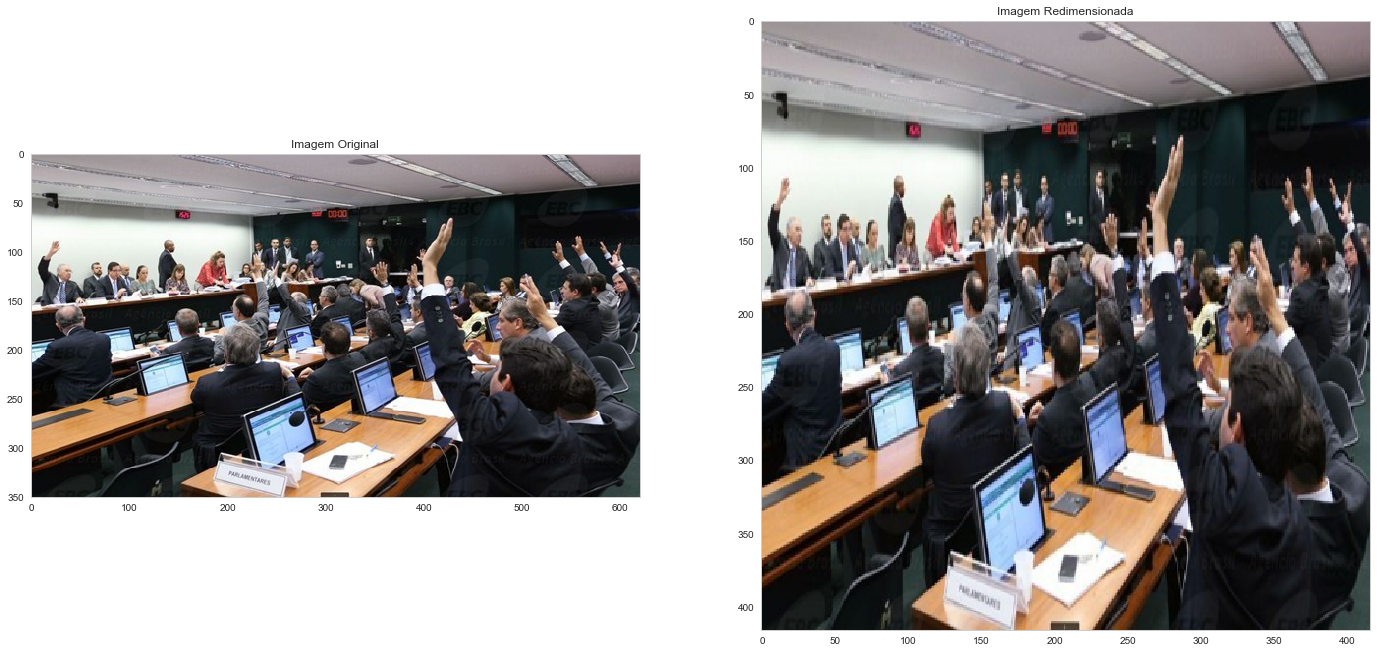

In [7]:
# Tamanho da figura
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregando imagem para classificar
img_path = "imagens/camara.jpg"
img = cv2.imread(img_path)

# Convertendo para o espaço de cores RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionando imagem para ser compatível com a primeira camada da rede neural  
resized_image = cv2.resize(original_image, (m.width, m.height))

# Exibição das imagens
plt.subplot(121)
plt.title("Imagem Original")
plt.imshow(original_image)
plt.subplot(122)
plt.title("Imagem Redimensionada")
plt.imshow(resized_image)
plt.show()

In [8]:
# Patamar de NMS (Non-Maximum Supression)
# Ajuste de sensibilidade de imagens com baixa luminosidade
nms_thresh = 0.6

# Patamar do IOU (Intersect of Union), indicador se o retângulo 
# de identificação de imagem foi adequadamente desenhado
iou_thresh = 0.4



It took 1.984 seconds to detect the objects in the image.

Number of Objects Detected: 24 

Objects Found and Confidence Level:

1. computador portátil: 0.999996
2. pessoa: 1.000000
3. computador portátil: 0.982110
4. tv: 0.709401
5. pessoa: 1.000000
6. computador portátil: 0.987804
7. pessoa: 1.000000
8. pessoa: 1.000000
9. computador portátil: 0.997870
10. pessoa: 1.000000
11. pessoa: 1.000000
12. pessoa: 1.000000
13. pessoa: 0.999995
14. pessoa: 1.000000
15. pessoa: 1.000000
16. pessoa: 0.999999
17. pessoa: 0.999972
18. pessoa: 0.999999
19. copo: 0.999950
20. pessoa: 1.000000
21. computador portátil: 0.961230
22. celular: 0.998715
23. pessoa: 0.999998
24. pessoa: 0.999998


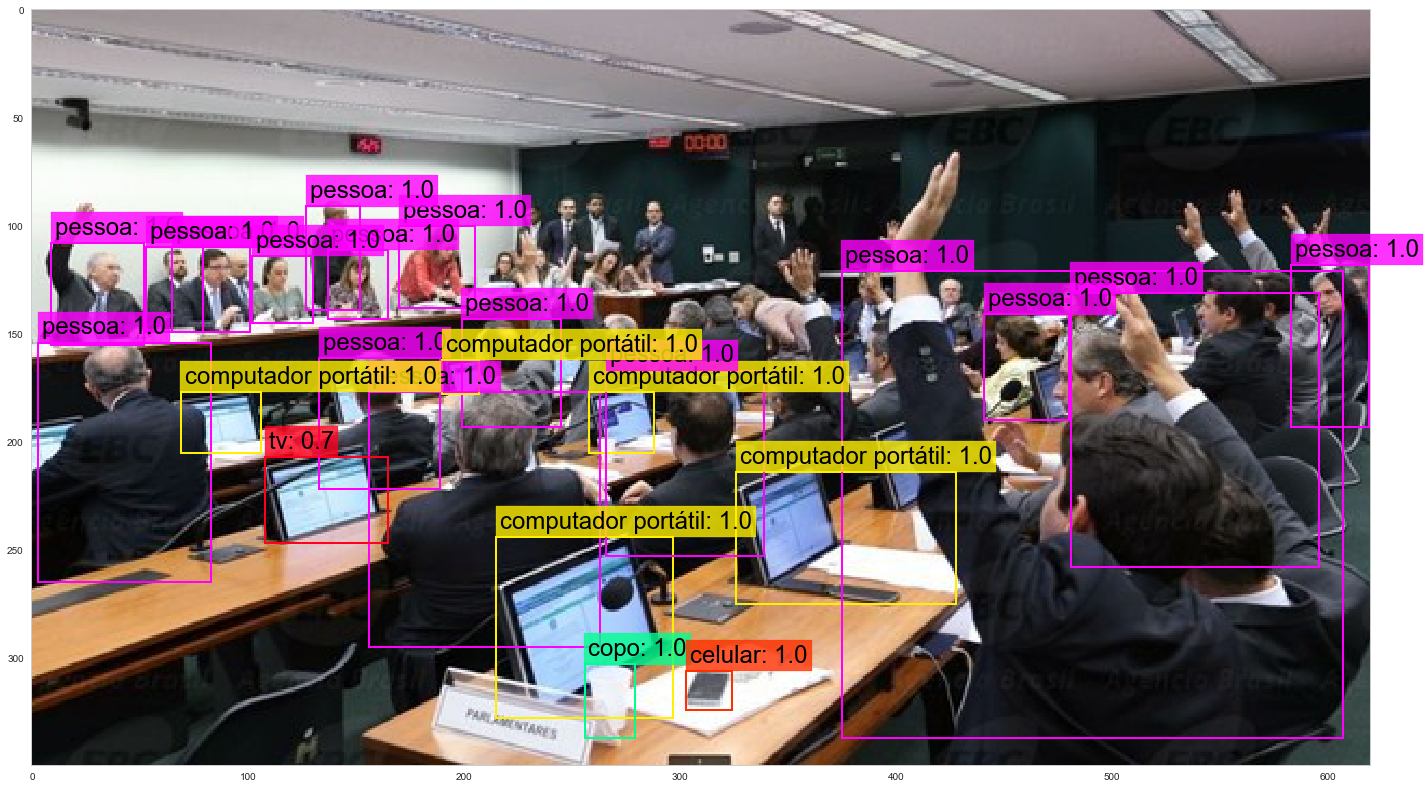

In [9]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregar imagem para classificação
img = cv2.imread(img_path)

# Conversão para o espaço RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamento para adatapção da primeira camada da rede neural 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Deteteção de objetos na imagem
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Objetos encontrados e nível de confiança
print_objects(boxes, class_names)

# Desenho no gráfico com os regângulos e rótulos
plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [10]:
list_objects(boxes, class_names)

['computador portátil',
 'pessoa',
 'computador portátil',
 'tv',
 'pessoa',
 'computador portátil',
 'pessoa',
 'pessoa',
 'computador portátil',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'pessoa',
 'copo',
 'pessoa',
 'computador portátil',
 'celular',
 'pessoa',
 'pessoa']